# Fitting models to training & test data

This notebook lays out a complete model fitting and checking workflow for 1-alpha and 2-alpha Q learning models fit to probabalistic selection task (PST) training and test phase data ([Frank et al., 2004](https://www.science.org/doi/10.1126/science.1102941), [2007](https://www.pnas.org/content/104/41/16311)) using Markov chain Monte Carlo (MCMC).

### Setup

#### Python dependencies

In [1]:
import os
os.chdir('..')
    # may need to be run initially if working directory is the notebook folder
%load_ext rpy2.ipython
    # warnings about quartz on Windows can be ignored (https://github.com/rpy2/rpy2/issues/738)
light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

#### Load pstpipeline R package and data

In [2]:
%%R
remotes::install_github(
    "qdercon/pstpipeline", 
    quiet = TRUE,
    upgrade = "always"
)
# cmdstanr::set_cmdstan_path("/root/cmdstan-2.28.1")
cmdstanr::set_cmdstan_path("/home/qd01/cmdstan/cmdstan-2.28.1")
options(mc.cores = 4, width = 120)
    # number of chains to run in parallel + R output width

# run to use additional fonts outside of Docker image

# install.packages("showtext")
# sysfonts::font_add_google("Open Sans", "Open Sans")
# showtext::showtext_auto()

R[write to console]: Running `R CMD build`...

R[write to console]: CmdStan path set to: /home/qd01/cmdstan/cmdstan-2.28.1



In [3]:
%%R
all_res_split <- readRDS("data-raw/all_res_split.RDS")
head(tibble::as_tibble(all_res_split$non_distanced$ppt_info))

## to speed things up further, we can take a subsample

# all_res_split$non_distanced <- pstpipeline::take_subsample(
#     all_res_split$non_distanced, n_ppts = 20
# )
# all_res_split$distanced <- pstpipeline::take_subsample(
#     all_res_split$distanced, n_ppts = 20
# )
# tibble::as_tibble(all_res_split$non_distanced$ppt_info)

# A tibble: 6 × 78
  subjID         sessionID     studyID     distanced exclusion final_block_AB final_block_CD final_block_EF total_points
  <chr>          <chr>         <chr>       <lgl>         <dbl>          <dbl>          <dbl>          <dbl>        <int>
1 a82f81ad2052b… 6081a55945b0… 608027ae53… FALSE             0           0.5           0.526           0.5          4575
2 7516cf0fce1d3… 60816b85d228… 60801cc3b3… FALSE             0           0.55          0.579           0.6          4625
3 b5df682d64134… 60816cb03a7a… 608025f751… FALSE             0           0.7           0.55            0.55         4600
4 3c1c4cadb651a… 60817da775e7… 6080284fbb… FALSE             0           0.5           0.8             0.8          4900
5 8fb49dbc5f643… 608178293f8e… 608027ae53… FALSE             0           0.9           0.95            0.2          4875
6 12252bc633237… 608177c16d43… 608026caa5… FALSE             0           0.85          0.35            0.55         4375
# … with 69 m

# Q-learning models: background

Model-free reinforcement learning (RL) in the PST is commonly modelled using Q-learning (QL) models. 

In QL models, the weight or Q-value $Q_t(s_t, a_t)$ for a given action $a$ in state $s$ at time $t$ is an estimate of the state-action value, which can in turn be understood as an estimate of the expected sum of future rewards, conditional on that action at time $t$. Q-values are updated trial-by-trial based on prediction errors $\delta_t$:

$Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$

Here, $\alpha$ is the learning rate - in this task, lower values suggest that Q-values are being integrated more over time, while higher values indicate higher sensitivity to recent trials. In bandit tasks such as the PST, it can be shown that selecting a certain action/choice does not affect the transition to future states ([Sutton & Barto, 1998](https://mitpress.mit.edu/books/reinforcement-learning)), and so $\delta_t$ can be given as follows, where $r_t$ is the reward (i.e., positive or negative feedback) obtained at time $t$:

$\delta_t = r_t - Q_t(s_t, a_t)$

Given Luce's choice axiom$^1$, these state-action values can be converted to probabilities using a softmax function for a binary choice:

$P_t(s_t, a_t) = \frac{\exp{(Q_t(s_t, a_t)*\beta})}{1-\exp{(Q_t(s_t, a_t)*\beta})}$

where $\beta$ is an inverse temperature parameter, lower values of which indicate higher stochasticity in choices. Taking logits, it can be shown that this simplifies to the following, where $b_t$ is the alternative (avoided) choice in the pair:

$logit[P_t(s_t, a_t)] = \beta[Q_t(s_t, a_t) - Q_t(s_t, b_t)]$

In all of the following code blocks, the Q-learning models are fitted in a hierarchical Bayesian manner, with uninformative group-level priors on each of the parameters of interest; the trials are iterated over, and the posterior density updated assuming the chosen option follows a Bernoulli logistic distribution with the chance-of-success parameter = $\beta[Q_t(s_t, a_t) - Q_t(s_t, b_t)]$.

$^1$The absence of other symbols from the choices at each trial is assumed to not affect the probability of chosing one over the other.

# Training data

## Model fits

### 2 learning rates

The primary model of interest for the training phase of the PST is an extended QL model with two learning rates: $\alpha_{gain}$ and $\alpha_{loss}$ ([Frank et al., 2007](https://www.pnas.org/content/104/41/16311)). In this model, two different parameters are used to update the state-action values:

$Q_{t+1}(s_t, a_t) = \left\{ \begin{array}{ll}
Q_t(s_t, a_t) + \alpha_{gain}\delta_t & \text{if } \delta_t \geq  0, \text{ or} \\
Q_t(s_t, a_t) + \alpha_{loss}\delta_t & \text{if } \delta_t < 0 \end{array} \right.$

As $\delta_t < 0$ only when feedback is negative (i.e., $r_t$ = 0), higher $\alpha_{loss}$ values can be interpreted as increased sensitivity to recent negative feedback (and so reduced integration over trials), while higher $\alpha_{loss}$ values suggest increased sensitivity to recent positive feedback.

#### Non-distanced participants

In [4]:
%%R
mcmc_2a_train_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "2a", exp_part = "training", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/2a/model_fits/non-distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_2a_train_nd)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  91.4 seconds.
Running MCMC with 4 parallel chains...

Chain 4 finished in 147821.0 seconds.
Chain 2 finished in 148980.0 seconds.
Chain 3 finished in 149964.0 seconds.
Chain 1 finished in 150372.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 149284.2 seconds.
Total execution time: 150373.4 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/non-distanced/pst_gainloss_Q_training-202112052155-1-2c62d3.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/non-distanced/pst_gainloss_Q_training-202112052155-2-2c62d3.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/non-distanced/pst_gainloss_Q_training-202112052155-3-2c62d3.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/non-distanced/pst_gainloss_Q_training-202112052155-4-2c62d3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for

#### Distanced participants

In [5]:
%%R
mcmc_2a_train_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "2a", exp_part = "training", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/2a/model_fits/distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_2a_train_dis)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  107.6 seconds.
Running MCMC with 4 parallel chains...

Chain 4 finished in 120844.0 seconds.
Chain 3 finished in 135866.0 seconds.
Chain 1 finished in 143272.0 seconds.
Chain 2 finished in 144857.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 136209.8 seconds.
Total execution time: 144859.2 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/distanced/pst_gainloss_Q_training-202112011200-1-14887d.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/distanced/pst_gainloss_Q_training-202112011200-2-14887d.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/distanced/pst_gainloss_Q_training-202112011200-3-14887d.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a/model_fits/distanced/pst_gainloss_Q_training-202112011200-4-14887d.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
N

### 1 learning rate

The training phase of the PST may also be adequately modelled with a single learning-rate model, with a simple update equation for the state-action values: $Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$. Evidence that this model fit our data better would indicate that recency effects (as captured by the learning rate $\alpha$) are not conditional on the type of feedback received.

#### Non-distanced participants

In [6]:
%%R
mcmc_1a_train_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/1a/model_fits/non-distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_1a_train_nd)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  100.4 seconds.
Running MCMC with 4 parallel chains...

Chain 4 finished in 124037.0 seconds.
Chain 1 finished in 126546.0 seconds.
Chain 3 finished in 135717.0 seconds.
Chain 2 finished in 137316.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 130904.0 seconds.
Total execution time: 137317.7 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/non-distanced/pst_Q_training-202112131925-1-0310d0.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/non-distanced/pst_Q_training-202112131925-2-0310d0.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/non-distanced/pst_Q_training-202112131925-3-0310d0.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/non-distanced/pst_Q_training-202112131925-4-0310d0.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transiti

#### Distanced participants

In [7]:
%%R
mcmc_1a_train_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/1a/model_fits/distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_1a_train_dis)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  98.3 seconds.
Running MCMC with 4 parallel chains...

Chain 1 finished in 74351.3 seconds.
Chain 3 finished in 74896.6 seconds.
Chain 2 finished in 76213.1 seconds.
Chain 4 finished in 76815.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 75569.0 seconds.
Total execution time: 76817.9 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/distanced/pst_Q_training-202112042052-1-3000e3.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/distanced/pst_Q_training-202112042052-2-3000e3.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/distanced/pst_Q_training-202112042052-3-3000e3.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a/model_fits/distanced/pst_Q_training-202112042052-4-3000e3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-

## Model checks

### Posterior distributions of parameter means

#### 2 learning rates

In [8]:
%%R
draws_nd_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_mcmc_80000_draws_list.RDS"
)
draws_dis_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_mcmc_80000_draws_list.RDS"
)

model_checks_nd_2a <- pstpipeline::check_learning_models(
    draws_nd_2a, font = "Open Sans"
)
model_checks_dis_2a <- pstpipeline::check_learning_models(
    draws_dis_2a, font = "Open Sans"
)

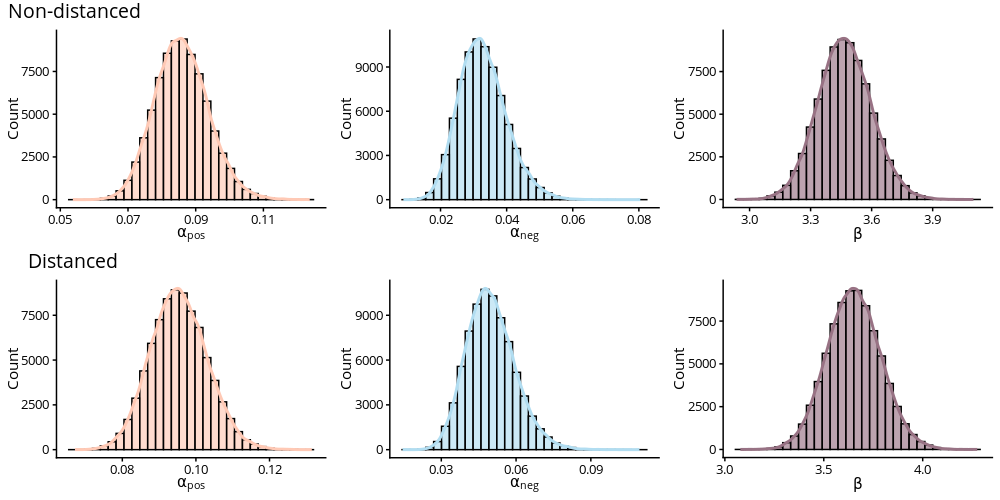

In [9]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.7, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_nd_2a$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 5.25, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_dis_2a$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

#### 1 learning rate

In [10]:
%%R
draws_nd_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_mcmc_80000_draws_list.RDS"
)
draws_dis_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_mcmc_80000_draws_list.RDS"
)

model_checks_nd_1a <- pstpipeline::check_learning_models(
    draws_nd_1a, font = "Open Sans"
)
model_checks_dis_1a <- pstpipeline::check_learning_models(
    draws_dis_1a, font = "Open Sans"
)

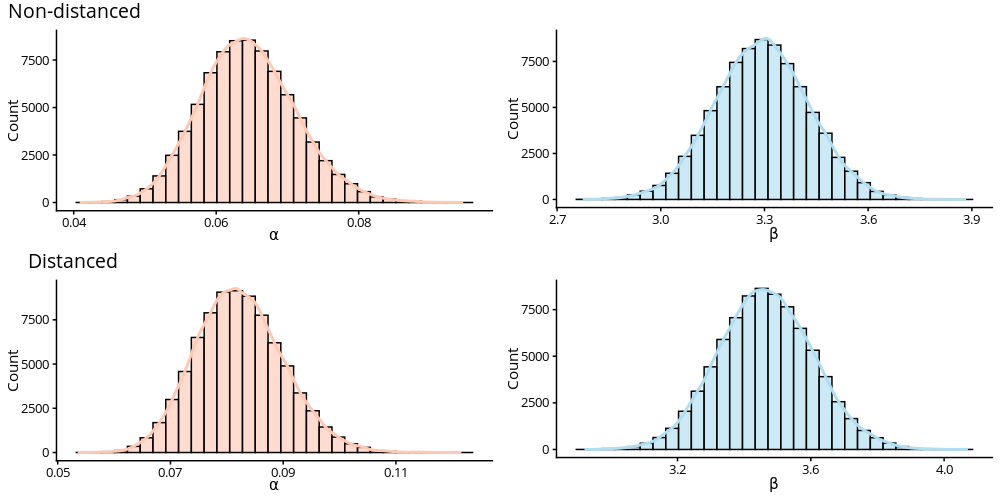

In [11]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.7, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_nd_1a$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 5.25, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_dis_1a$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

### MCMC diagnostics

#### 2 learning rates

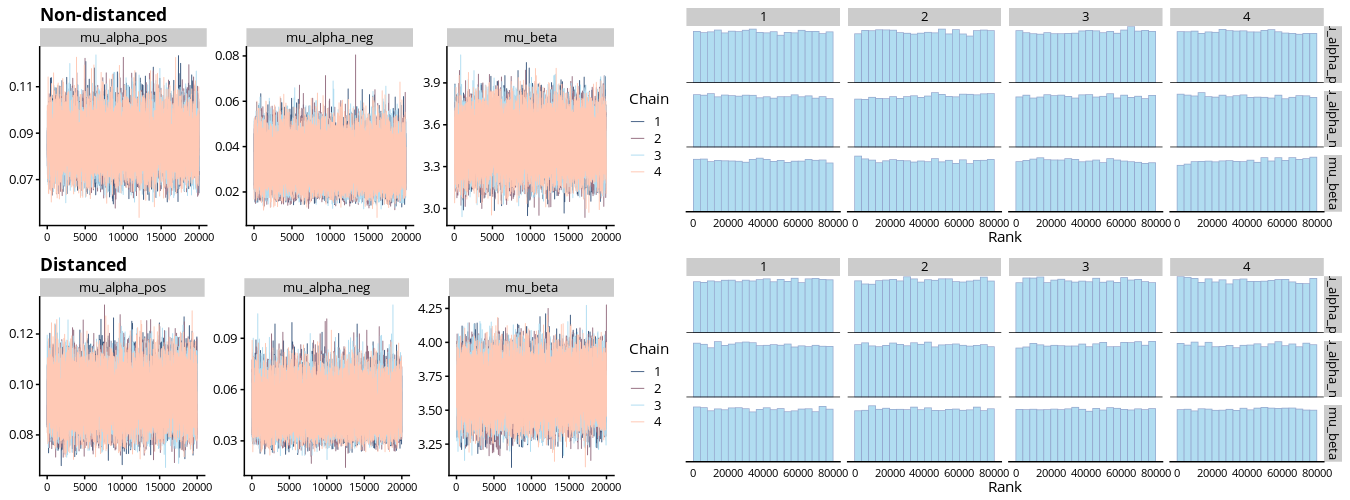

In [12]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    model_checks_nd_2a$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)), 
    model_checks_nd_2a$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)),
    model_checks_dis_2a$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)), 
    model_checks_dis_2a$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)),
    nrow = 2,
    ncol = 2
)

#### 1 learning rate

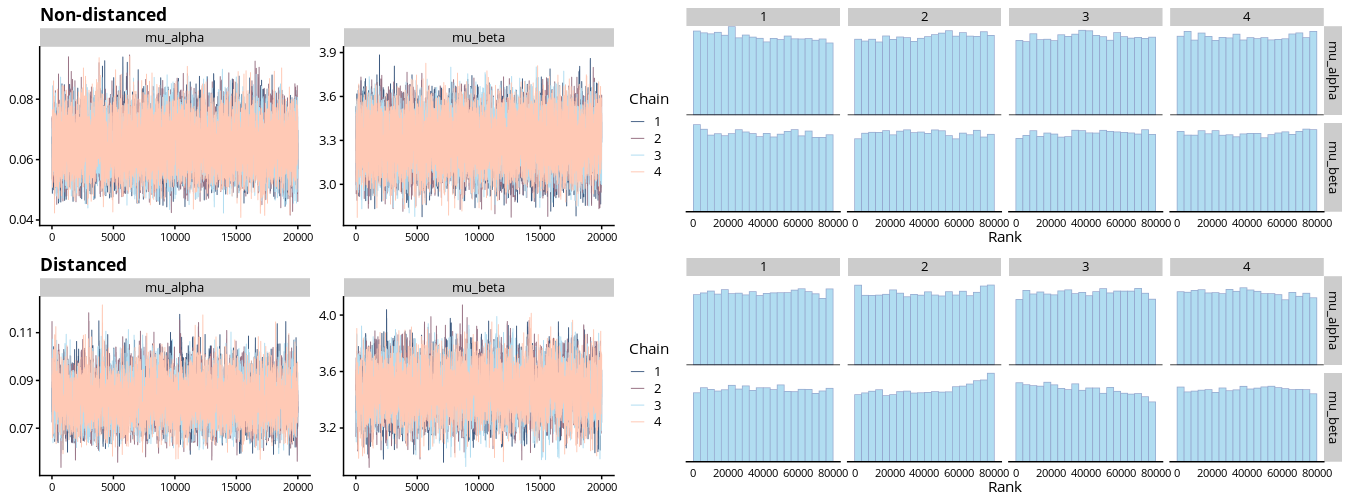

In [13]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    model_checks_nd_1a$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)), 
    model_checks_nd_1a$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)),
    model_checks_dis_1a$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)), 
    model_checks_dis_1a$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 8)),
    nrow = 2,
    ncol = 2
)

## Model comparisons

### Bayesian fit metrics

First, we use two fully Bayesian numerical fit metrics which aim to quantify the out-of-sample predictive accuracy of the models: the expected log-predictive density (ELPD), and the leave-one-out information criterion (LOOIC).

#### Non-distanced

In [14]:
%%R
loo_obj_1a_train_nd <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_mcmc_80000_loo_obj.RDS"
)
loo_obj_2a_train_nd <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_mcmc_80000_loo_obj.RDS"
)
comp_train_nd <- loo::loo_compare(loo_obj_1a_train_nd, loo_obj_2a_train_nd)
print(comp_train_nd, digits = 1, simplify = FALSE)

       elpd_diff se_diff  elpd_loo se_elpd_loo p_loo    se_p_loo looic    se_looic
model2      0.0       0.0 -93022.8   1031.7      1088.4     18.1 186045.6   2063.5
model1   -802.3      82.4 -93825.1   1029.7       835.4     19.1 187650.1   2059.5


#### Distanced

In [15]:
%%R
loo_obj_1a_train_dis <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_mcmc_80000_loo_obj.RDS"
)
loo_obj_2a_train_dis <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_mcmc_80000_loo_obj.RDS"
)
comp_train_dis <- loo::loo_compare(loo_obj_1a_train_dis, loo_obj_2a_train_dis)
print(comp_train_dis, digits = 1, simplify = FALSE)

       elpd_diff se_diff  elpd_loo se_elpd_loo p_loo    se_p_loo looic    se_looic
model2      0.0       0.0 -86700.6   1089.3      1111.8     19.2 173401.3   2178.6
model1   -709.2      77.0 -87409.9   1090.8       851.3     17.5 174819.8   2181.6


Overall, it seems that the less parsimonious 2-alpha model appears to have better (expected) out-of-sample predictive accuracy than the simpler 1-alpha model. Is this better fit apparent if we sample choices from the posterior distribution and plot them against the observed data?

### Posterior predictive checks

It is recommended to restart the kernel after running each cell as this process is very memory intensive with this many posterior draws.

#### Generate quantities and save predictions for 2-alpha model

In [16]:
%%R
fit_nd_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_mcmc_80000.RDS"
)
stanlist_nd_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_mcmc_80000_stan_datalist.RDS"
)
fit_dis_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_mcmc_80000.RDS"
)
stanlist_dis_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_mcmc_80000_stan_datalist.RDS"
)

out_files_nd_2a <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_2a, data_list = stanlist_nd_2a, 
    out_dir = "outputs/cmdstan/2a/predictions/non-distanced",
    return_type = "paths"
)
out_files_dis_2a <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_2a, data_list = stanlist_dis_2a, 
    out_dir = "outputs/cmdstan/2a/predictions/distanced",
    return_type = "paths"
)
saveRDS(out_files_nd_2a, "outputs/cmdstan/2a/predictions/non-distanced/out_files_nd_2a.RDS")
saveRDS(out_files_dis_2a, "outputs/cmdstan/2a/predictions/distanced/out_files_dis_2a.RDS")
rm(fit_nd_2a, fit_dis_2a)

R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 3 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 1345.3 seconds.


R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 4 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 1282.3 seconds.


In [17]:
%%R
out_files_nd_2a <- readRDS("outputs/cmdstan/2a/predictions/non-distanced/out_files_nd_2a.RDS")
obs_nd_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_nd_2a <- pstpipeline::get_preds_by_chain(
    out_files_nd_2a, obs_df = obs_nd_2a, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/2a/predictions/non-distanced",
    memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 2986.9 seconds.



In [18]:
%%R
# restart kernel to clear memory first!
out_files_dis_2a <- readRDS("outputs/cmdstan/2a/predictions/distanced/out_files_dis_2a.RDS")
obs_dis_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_dis_2a <- pstpipeline::get_preds_by_chain(
    out_files_dis_2a, obs_df = obs_dis_2a, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/2a/predictions/distanced",
    memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 3687.6 seconds.



#### Generate quantities and save predictions for 1-alpha model

In [19]:
%%R
fit_nd_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_mcmc_80000.RDS"
)
stanlist_nd_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_mcmc_80000_stan_datalist.RDS"
)
fit_dis_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_mcmc_80000.RDS"
)
stanlist_dis_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_mcmc_80000_stan_datalist.RDS"
)

out_files_nd_1a <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_1a, data_list = stanlist_nd_1a, 
    out_dir = "outputs/cmdstan/1a/predictions/non-distanced",
    return_type = "paths"
)
out_files_dis_1a <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_1a, data_list = stanlist_dis_1a, 
    out_dir = "outputs/cmdstan/1a/predictions/distanced",
    return_type = "paths"
)
saveRDS(out_files_nd_1a, "outputs/cmdstan/1a/predictions/non-distanced/out_files_nd_1a.RDS")
saveRDS(out_files_dis_1a, "outputs/cmdstan/1a/predictions/distanced/out_files_dis_1a.RDS")
rm(fit_nd_1a, fit_dis_1a)

R[write to console]: Compiling Stan program...



Running standalone generated quantities after 4 MCMC chains, all chains in parallel .../-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/

Chain 4 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 1312.7 seconds.


R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 1316.5 seconds.


In [20]:
%%R
out_files_nd_1a <- readRDS("outputs/cmdstan/1a/predictions/non-distanced/out_files_nd_1a.RDS")
obs_nd_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_nd_1a <- pstpipeline::get_preds_by_chain(
    out_files_nd_1a, obs_df = obs_nd_1a, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/1a/predictions/non-distanced",
    memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 3034.3 seconds.



In [21]:
%%R
# restart kernel to clear memory first!
out_files_dis_1a <- readRDS("outputs/cmdstan/1a/predictions/distanced/out_files_dis_1a.RDS")
obs_dis_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_dis_1a <- pstpipeline::get_preds_by_chain(
    out_files_dis_1a, obs_df = obs_dis_1a, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/1a/predictions/distanced",
    memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 3940.8 seconds.



#### Plot predictions against observed training data

In [22]:
%%R
obs_df_preds <- list()
obs_df_preds$nd_2a <- obs_df_preds$dis_2a <- obs_df_preds$nd_1a <- obs_df_preds$dis_1a <- list()
obs_df_preds$nd_2a$indiv_obs_df <- readRDS("outputs/cmdstan/2a/predictions/non-distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$nd_2a$trial_obs_df <- readRDS("outputs/cmdstan/2a/predictions/non-distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$dis_2a$indiv_obs_df <- readRDS("outputs/cmdstan/2a/predictions/distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$dis_2a$trial_obs_df <- readRDS("outputs/cmdstan/2a/predictions/distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$nd_1a$indiv_obs_df <- readRDS("outputs/cmdstan/1a/predictions/non-distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$nd_1a$trial_obs_df <- readRDS("outputs/cmdstan/1a/predictions/non-distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$dis_1a$indiv_obs_df <- readRDS("outputs/cmdstan/1a/predictions/distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$dis_1a$trial_obs_df <- readRDS("outputs/cmdstan/1a/predictions/distanced/trial_block_avg_hdi_ppcs_df.RDS")

In [23]:
%%R
grp_names <- c("nd_2a", "nd_1a", "dis_2a", "dis_1a")
grp_titles <- c("Non distanced (2-alpha)", "Non-distanced (1-alpha)",
                "Distanced (2-alpha)", "Distanced (1-alpha)")
pred_plt_list <- vector("list", 3)
pred_plt_list$cum_prob <- pred_plt_list$diffs <- pred_plt_list$indiv_pstrs <- list()

for (grp in grp_names) {
    pred_plts <- pstpipeline::plot_ppc(
        train_indiv = list(obs_df_preds[[grp]]$indiv_obs_df, c(20, 120), c(20, 120)),
        train_trials = list(obs_df_preds[[grp]]$trial_obs_df, "all_trials"),
        group_title = grp_titles[which(grp_names == grp)], font = "Open Sans", 
        font_size = 11
    )
    pred_plt_list$cum_prob[[grp]] <- pred_plts[[1]]
    pred_plt_list$diffs[[grp]] <- pred_plts[[2]]
    pred_plt_list$indiv_pstrs[[grp]] <- pred_plts[[3]]    
}

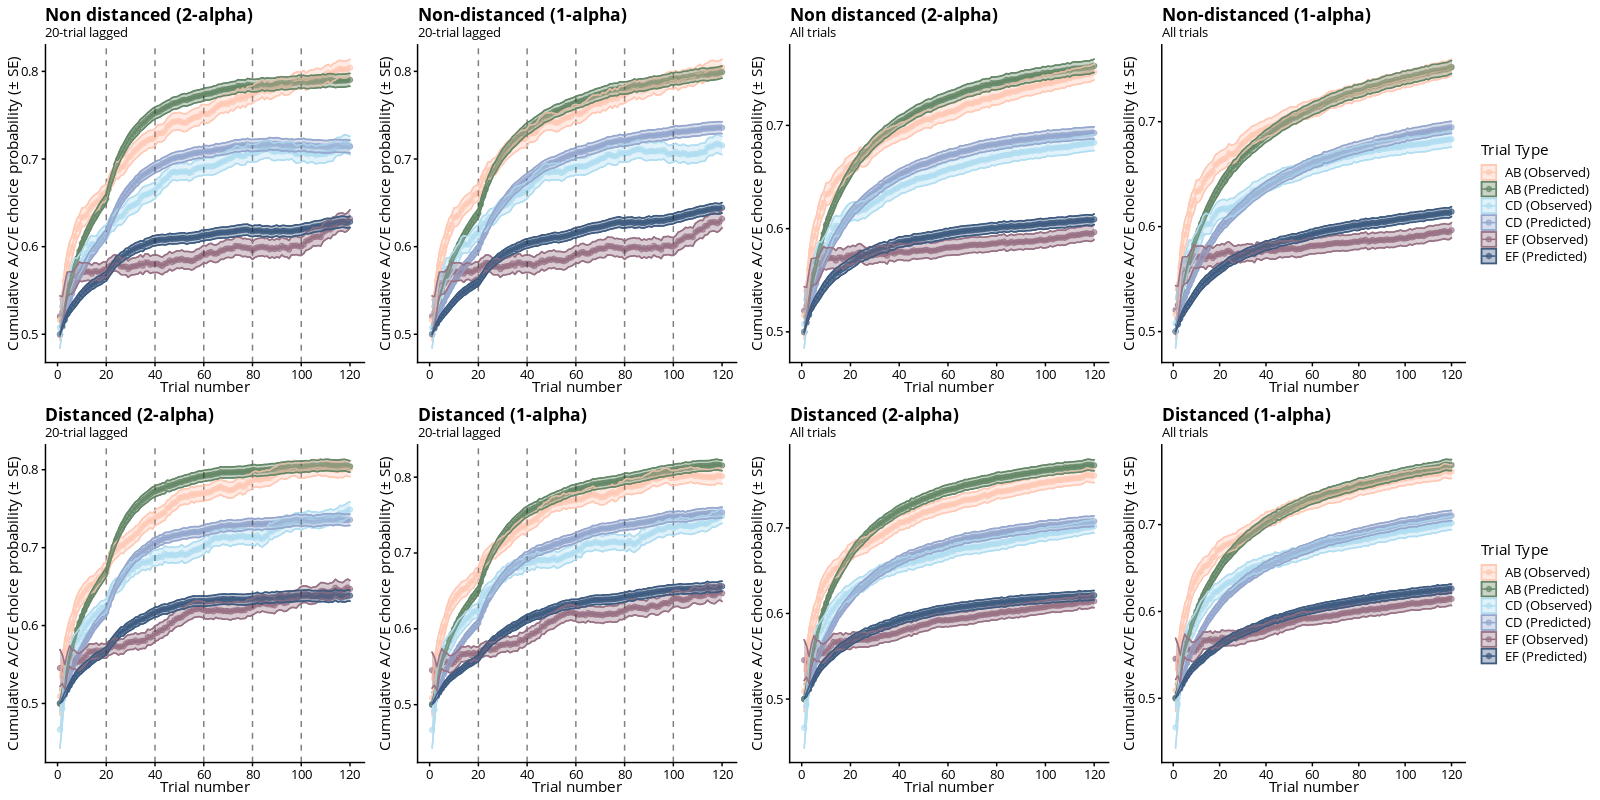

In [24]:
%%R -w 16 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$cum_prob[[1]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[2]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[1]][[2]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[2]][[2]],
    pred_plt_list$cum_prob[[3]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[4]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[3]][[2]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[4]][[2]],
    nrow = 2,
    ncol = 4,
    rel_widths = c(1,1,1,1.3)
)

These plots show the choice probabilities predicted from the model (i.e., $\frac{\sum_{1}^{n}{choice}}{n}$, where choice = 1 or 0, and n is the total number of posterior draws), plotted against the observed choice probabilities.

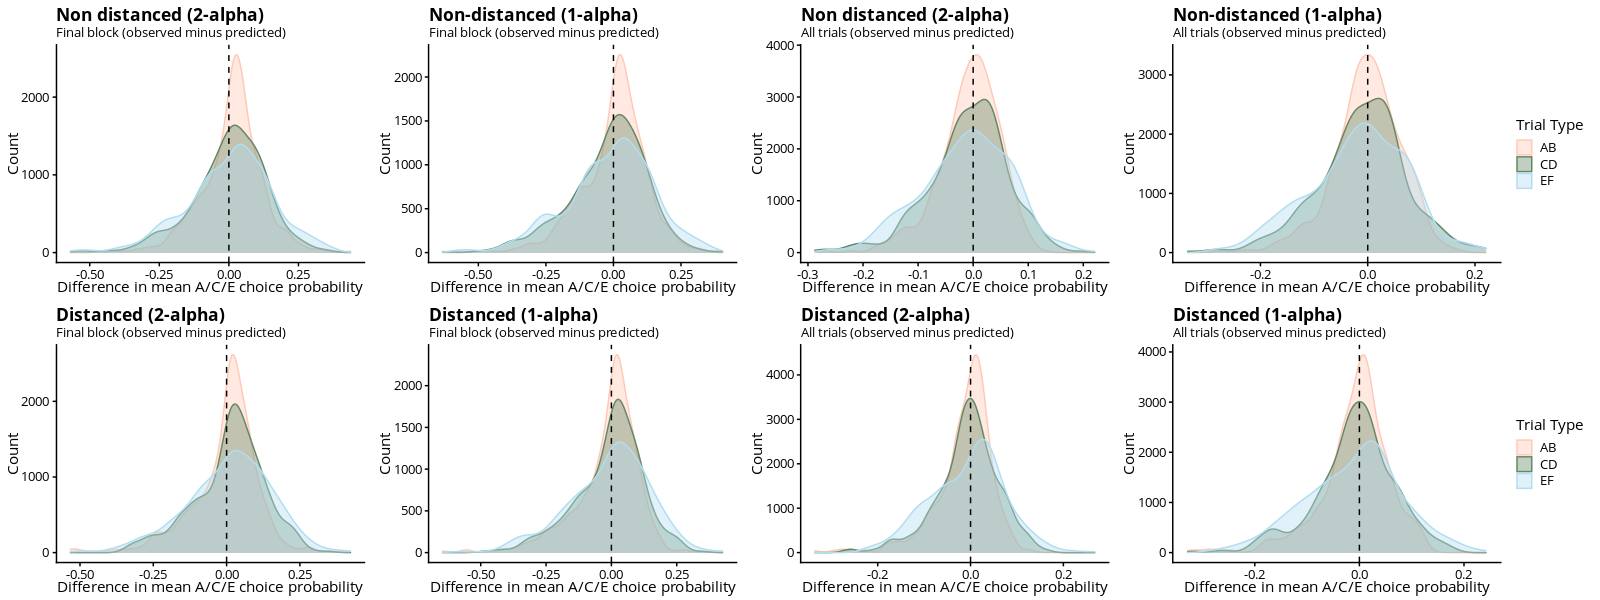

In [25]:
%%R -w 16 -h 6 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$diffs[[1]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[2]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[1]][[2]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[2]][[2]],
    pred_plt_list$diffs[[3]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[4]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[3]][[2]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[4]][[2]],
    nrow = 2,
    ncol = 4,
    rel_widths = c(1,1,1,1.3)
)

These plots show the distributions of differences between the mean observed choice and the mean predicted choice for each trial type, over all trials and the final block (i.e., last 20 trials).

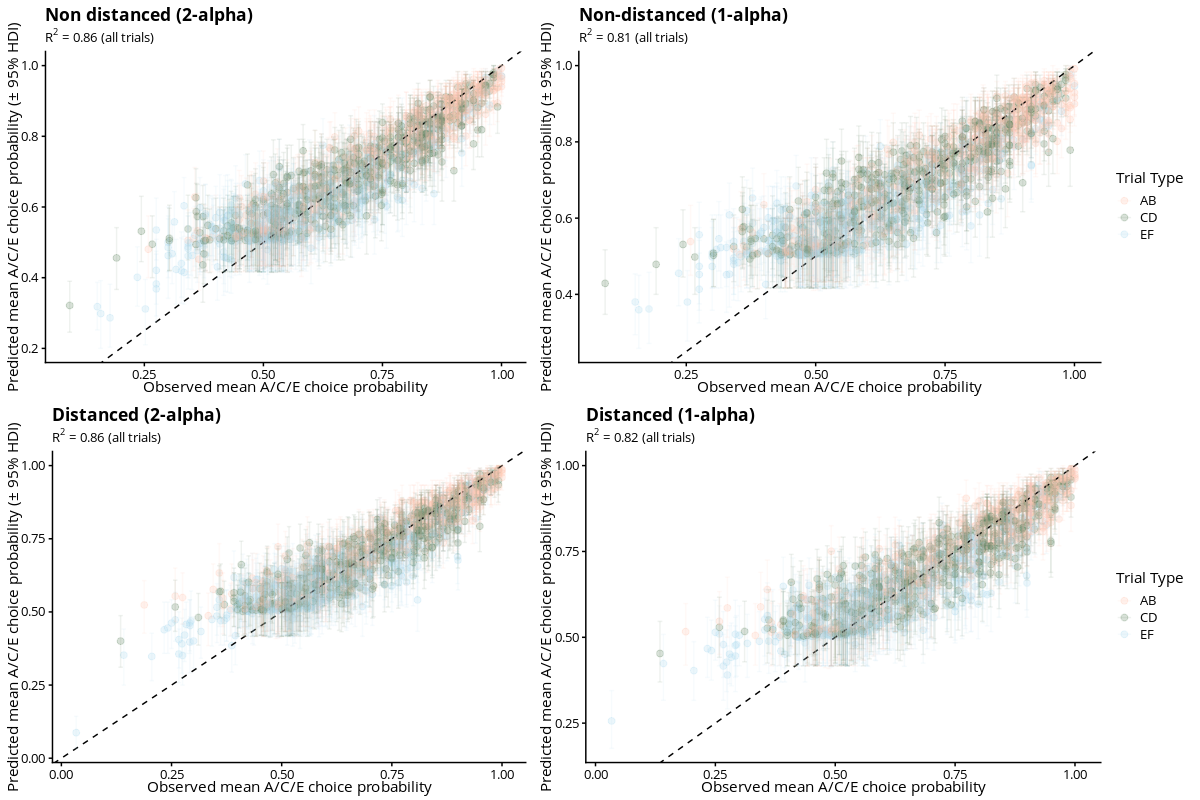

In [26]:
%%R -w 12 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$indiv_pstrs[[1]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$indiv_pstrs[[2]][[1]],
    pred_plt_list$indiv_pstrs[[3]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$indiv_pstrs[[4]][[1]],
    ncol = 2,
    rel_widths = c(1,1.25)
)

These plots show the posterior means and 95% HDIs for the number of choices of each type over the whole task, across all posterior draws, plotted against the observed overall choice probabilities for each individual.

In [27]:
%%R
dir.create(file.path("outputs/cmdstan/plots"))
saveRDS(pred_plt_list, "outputs/cmdstan/plots/training_posterior_predictions.RDS")

# clear all objects except raw data
rm(list = setdiff(ls(), "all_res_split"))

## Parameter recovery

A useful property of generative models is that it is possible to simulate data from them. Parameter recovery refers to a three-step process: simulating data from a model from a set of (known) parameter values, fitting the models to these simulated data, and then checking whether the fitted parameters are close to those that went in originally. Here, we sample from a gamma distribution (i.e., positively skewed, bounded by 0) for the alphas, and from a Normal distribution for the beta parameter.

In [28]:
%%R
# create simulated_data directories manually to save into
dir.create(file.path("outputs/cmdstan/2a/model_fits/simulated_data"))
dir.create(file.path("outputs/cmdstan/1a/model_fits/simulated_data"))

train_sim_2a <- pstpipeline::simulate_QL(
    sample_size = 500, 
    alpha_pos_dens = c(shape = 2, scale = 0.1),
    alpha_neg_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
train_sim_1a <- pstpipeline::simulate_QL(
    sample_size = 500,
    gain_loss = FALSE,
    alpha_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
saveRDS(train_sim_2a, "outputs/cmdstan/2a/model_fits/simulated_data/training_2a_sim.RDS")
saveRDS(train_sim_1a, "outputs/cmdstan/1a/model_fits/simulated_data/training_1a_sim.RDS")

  |==============================================================================================================| 100%

In [29]:
%%R
mcmc_2a_train_sim <- pstpipeline::fit_learning_model(
    train_sim_2a$sim, model = "2a", exp_part = "training",
    vb = FALSE, ppc = FALSE, model_checks = FALSE, par_recovery = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a/model_fits/simulated_data", 
    refresh = 0, iter_warmup = 4000, iter_sampling = 20000, 
    adapt_delta = 0.9, step_size = 1, max_treedepth = 10
);
rm(mcmc_2a_train_sim)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  95.2 seconds.
Running MCMC with 4 parallel chains...

Chain 4 finished in 64837.8 seconds.
Chain 3 finished in 65152.3 seconds.
Chain 2 finished in 65475.3 seconds.
Chain 1 finished in 65683.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 65287.2 seconds.
Total execution time: 65684.7 seconds.


In [30]:
%%R
mcmc_1a_train_sim <- pstpipeline::fit_learning_model(
    train_sim_1a$sim, model = "1a", exp_part = "training",
    vb = FALSE, ppc = FALSE, model_checks = FALSE, par_recovery = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a/model_fits/simulated_data", 
    refresh = 0, iter_warmup = 4000, iter_sampling = 20000, 
    adapt_delta = 0.9, step_size = 1, max_treedepth = 10
);
rm(mcmc_1a_train_sim)

R[write to console]: Compiling Stan program...



R[write to console]: Getting initial values from variational inference...



Finished in  82.2 seconds.
Running MCMC with 4 parallel chains...

Chain 2 finished in 33535.0 seconds.
Chain 1 finished in 33547.6 seconds.
Chain 4 finished in 33624.2 seconds.
Chain 3 finished in 33711.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 33604.6 seconds.
Total execution time: 33713.9 seconds.


#### 2-alpha training data model

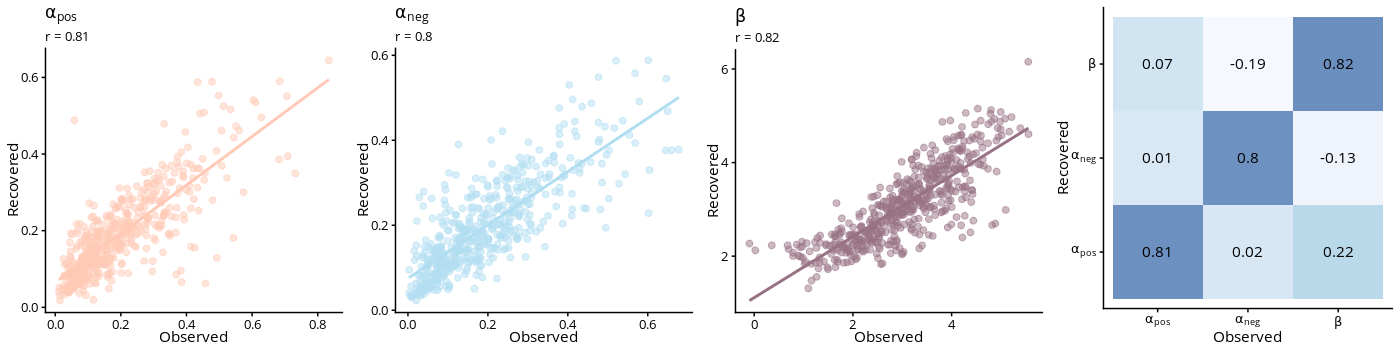

In [31]:
%%R -i light_pal -w 14 -h 3.5 --units in -r 100

sim_pst_training_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/simulated_data/training_2a_sim.RDS"
)
sim_training_2a_fitted <- readRDS(
    "outputs/cmdstan/2a/model_fits/simulated_data/fit_pst_training_2a_mcmc_80000_summary.RDS"
)

recovery_plots <- list()
recovery_plots$gain_loss <- pstpipeline::plot_recovery(
    sim_pst_training_2a$pars, sim_training_2a_fitted, pal = light_pal, font = "Open Sans"
)
recovery_plots$gain_loss

#### 1-alpha training data model

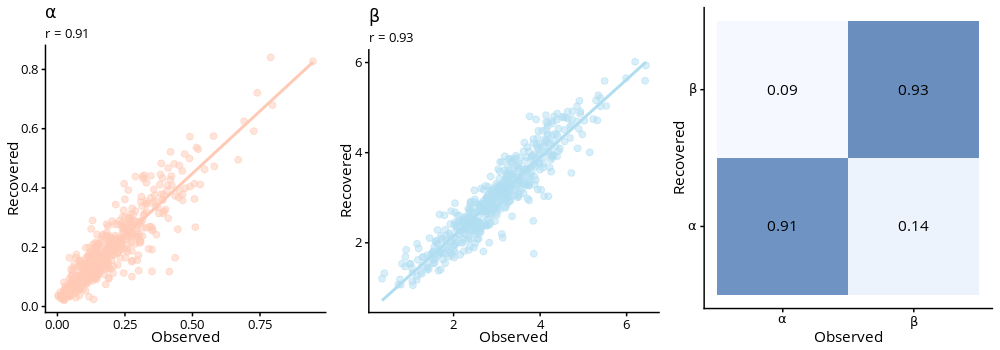

In [32]:
%%R -i light_pal -w 10 -h 3.5 --units in -r 100
sim_pst_training_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/simulated_data/training_1a_sim.RDS"
)
sim_training_1a_fitted <- readRDS(
    "outputs/cmdstan/1a/model_fits/simulated_data/fit_pst_training_1a_mcmc_80000_summary.RDS"
)

recovery_plots$std_1a <- pstpipeline::plot_recovery(
    sim_pst_training_1a$pars, sim_training_1a_fitted, pal = light_pal, font = "Open Sans"
)
recovery_plots$std_1a

In [33]:
%%R
saveRDS(recovery_plots, "outputs/cmdstan/plots/training_parameter_recovery_plots.RDS")

# clear all objects except raw data + free up memory
rm(list = setdiff(ls(), "all_res_split"))
invisible(gc())

# Test data

The aim for modelling the test data is similar to that for the training data. However, instead of trying to find parameter values which best explain each individual's training choices, we instead wish to find those that explain their test phase choices. Of course, during the test phase, there is no feedback; as such, the test parameters can be thought of as the learning rate / inverse temperature at the end of training which best fit the subsequent test choices: these are assumed to be fixed in the test phase. In practical terms, this means that the models are identical to those fitted to training data, except that at each iteration the posterior density is *also* incremented based on the test choices.

In mathematical terms this means that the probability of choosing one option over any other in the test phase is simply given by the following,

$P_t^{test}(s_t, a_t) = \frac{\exp{(Q_t(s_t, a_t)_{final}*\beta'})}{1-\exp{(Q_t(s_t, a_t)_{final}*\beta'})}$

where $\beta'$ and $Q_{final}$ correspond to the inverse temperature parameter and Q-values at the end of training respectively.

### 2 learning rates

#### Non-distanced participants

In [34]:
%%R
mcmc_2a_test_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "2a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/2a_test/model_fits/non-distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_2a_test_nd)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  108.1 seconds.
Running MCMC with 4 parallel chains...

Chain 2 finished in 144442.0 seconds.
Chain 1 finished in 145363.0 seconds.
Chain 4 finished in 145621.0 seconds.
Chain 3 finished in 146520.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 145486.5 seconds.
Total execution time: 146521.2 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/non-distanced/pst_gainloss_Q_test-202112281127-1-66997f.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/non-distanced/pst_gainloss_Q_test-202112281127-2-66997f.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/non-distanced/pst_gainloss_Q_test-202112281127-3-66997f.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/non-distanced/pst_gainloss_Q_test-202112281127-4-66997f.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transition

#### Distanced participants

In [35]:
%%R
mcmc_2a_test_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "2a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/2a_test/model_fits/distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_2a_test_dis)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  151.8 seconds.
Running MCMC with 4 parallel chains...

Chain 1 finished in 134340.0 seconds.
Chain 4 finished in 135316.0 seconds.
Chain 2 finished in 135566.0 seconds.
Chain 3 finished in 135942.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 135291.0 seconds.
Total execution time: 135943.7 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/distanced/pst_gainloss_Q_test-202112301135-1-339459.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/distanced/pst_gainloss_Q_test-202112301135-2-339459.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/distanced/pst_gainloss_Q_test-202112301135-3-339459.csv, /home/qd01/online-learning-project/outputs/cmdstan/2a_test/model_fits/distanced/pst_gainloss_Q_test-202112301135-4-339459.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergence

### 1 learning rate

#### Non-distanced participants

In [36]:
%%R
mcmc_1a_test_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/1a_test/model_fits/non-distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_1a_test_nd)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  100.1 seconds.
Running MCMC with 4 parallel chains...

Chain 3 finished in 82580.8 seconds.
Chain 1 finished in 126055.0 seconds.
Chain 2 finished in 126712.0 seconds.
Chain 4 finished in 127664.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 115753.0 seconds.
Total execution time: 127666.7 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/non-distanced/pst_Q_test-202201010147-1-632d34.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/non-distanced/pst_Q_test-202201010147-2-632d34.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/non-distanced/pst_Q_test-202201010147-3-632d34.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/non-distanced/pst_Q_test-202201010147-4-632d34.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent trans

#### Distanced participants

In [37]:
%%R
mcmc_1a_test_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, # will do manually
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", 
                "loo_obj", "diagnostics"), 
    out_dir = "outputs/cmdstan/1a_test/model_fits/distanced", refresh = 0, 
    iter_warmup = 4000, iter_sampling = 20000, adapt_delta = 0.9, 
    step_size = 1, max_treedepth = 10
)
rm(mcmc_1a_test_dis)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  82.0 seconds.
Running MCMC with 4 parallel chains...

Chain 2 finished in 68162.2 seconds.
Chain 3 finished in 68171.1 seconds.
Chain 4 finished in 68502.8 seconds.
Chain 1 finished in 113040.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 79469.0 seconds.
Total execution time: 113041.4 seconds.
Processing csv files: /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/distanced/pst_Q_test-202201021335-1-3bb1ae.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/distanced/pst_Q_test-202201021335-2-3bb1ae.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/distanced/pst_Q_test-202201021335-3-3bb1ae.csv, /home/qd01/online-learning-project/outputs/cmdstan/1a_test/model_fits/distanced/pst_Q_test-202201021335-4-3bb1ae.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Check

## Model checks

### Posterior distributions of parameter means

#### 2 learning rates

In [38]:
%%R
draws_nd_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_mcmc_80000_draws_list.RDS"
)
draws_dis_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_mcmc_80000_draws_list.RDS"
)

model_checks_nd_2a_test <- pstpipeline::check_learning_models(
    draws_nd_2a_test, test = TRUE, font = "Open Sans"
)
model_checks_dis_2a_test <- pstpipeline::check_learning_models(
    draws_dis_2a_test, test = TRUE, font = "Open Sans"
)

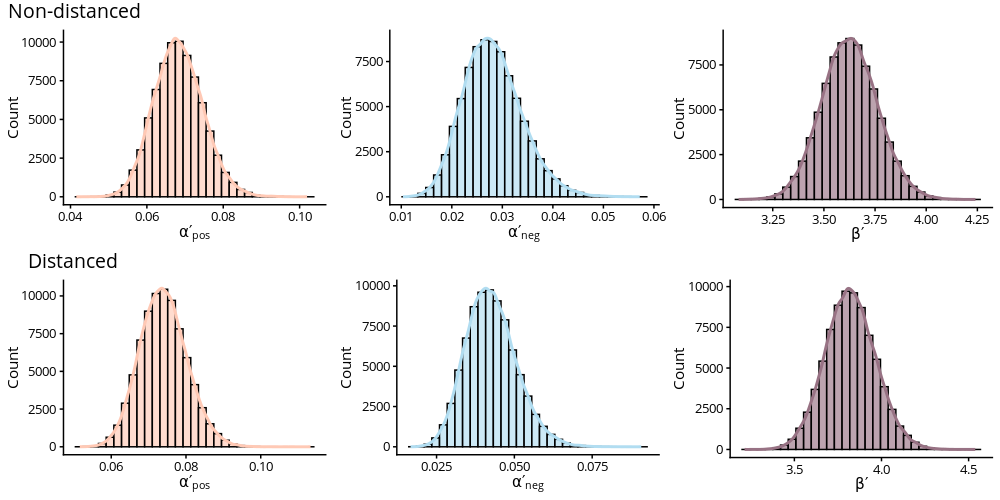

In [39]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.7, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_nd_2a_test$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 5.25, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_dis_2a_test$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

In [40]:
%%R
draws_nd_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_mcmc_80000_draws_list.RDS"
)
draws_dis_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_mcmc_80000_draws_list.RDS"
)

model_checks_nd_1a_test <- pstpipeline::check_learning_models(
    draws_nd_1a_test, test = TRUE, font = "Open Sans"
)
model_checks_dis_1a_test <- pstpipeline::check_learning_models(
    draws_dis_1a_test, test = TRUE, font = "Open Sans"
)

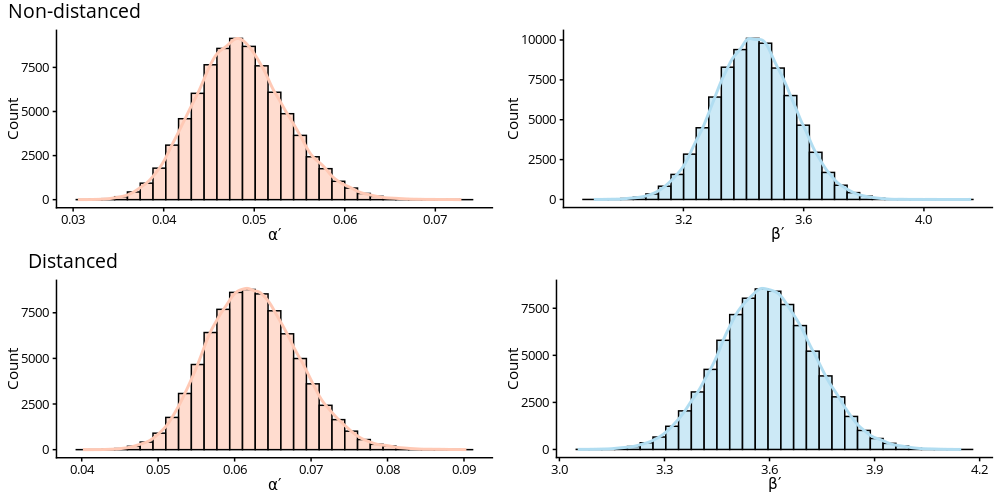

In [41]:
%%R -w 10 -h 5 --units in -r 100
cowplot::plot_grid(
    cowplot::ggdraw() + cowplot::draw_label(
        "Non-distanced", hjust = 3.7, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_nd_1a_test$mu_par_dens,
    cowplot::ggdraw() + cowplot::draw_label(
        "Distanced", hjust = 5.25, size = 14, 
        fontfamily = "Open Sans"
    ),
    model_checks_dis_1a_test$mu_par_dens,
    nrow = 4,
    rel_heights = c(0.1, 1, 0.1, 1)
)

### MCMC diagnostics

#### 2 learning rates

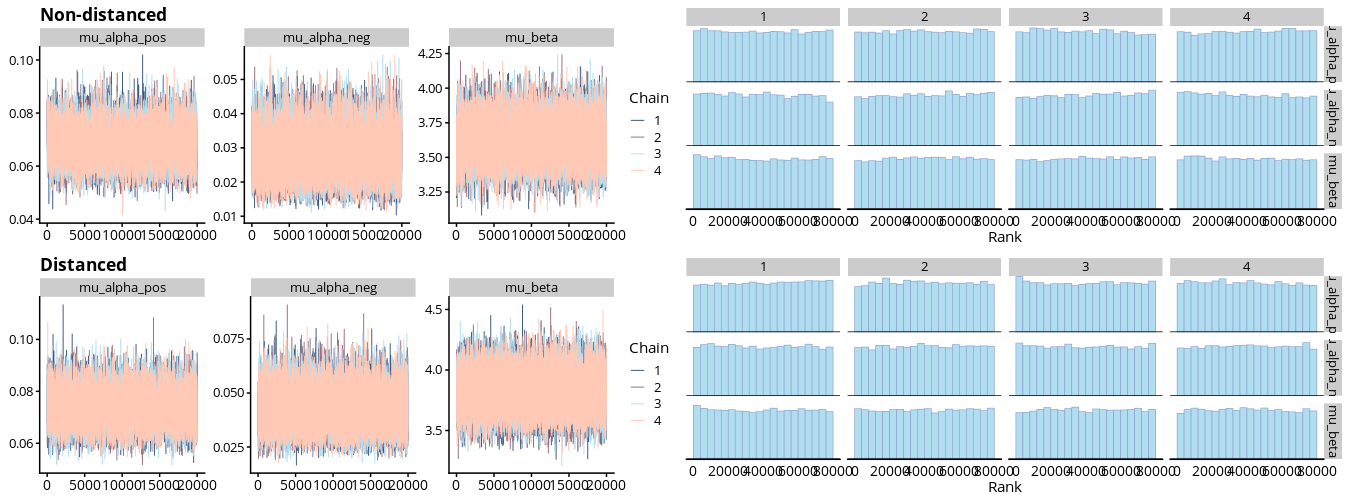

In [42]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    model_checks_nd_2a_test$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    model_checks_nd_2a_test$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    model_checks_dis_2a_test$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    model_checks_dis_2a_test$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    nrow = 2,
    ncol = 2
)

#### 1 learning rate

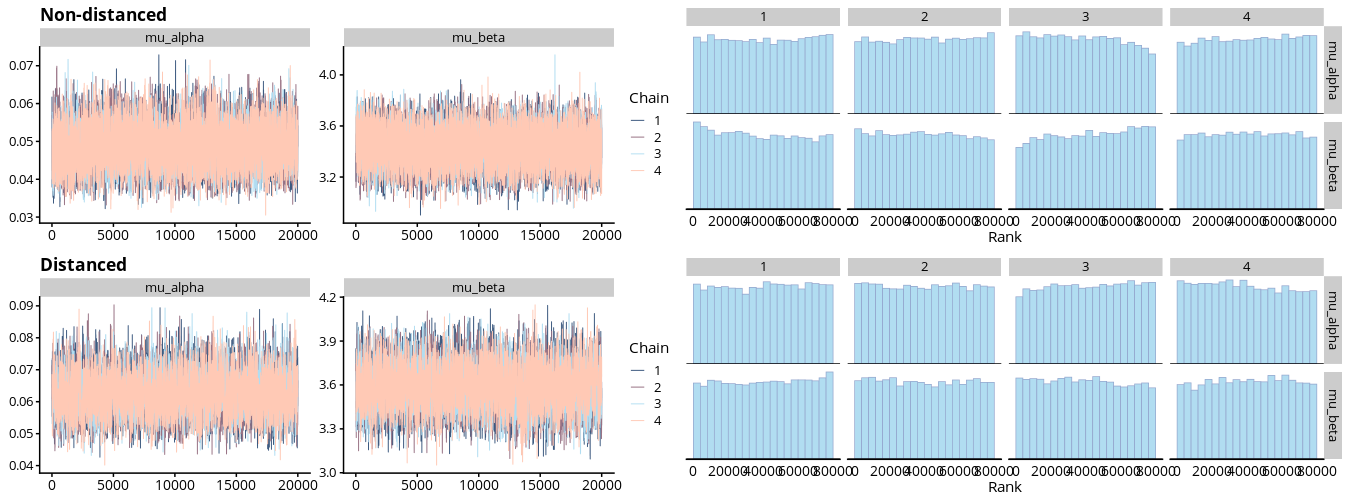

In [43]:
%%R -w 13.5 -h 5 --units in -r 100
cowplot::plot_grid(
    model_checks_nd_1a_test$diagnostics$trace + 
        ggplot2::ggtitle("Non-distanced") + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    model_checks_nd_1a_test$diagnostics$rank_hist +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    model_checks_dis_1a_test$diagnostics$trace + 
        ggplot2::ggtitle("Distanced") +
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)), 
    model_checks_dis_1a_test$diagnostics$rank_hist + 
        ggplot2::theme(axis.text.x = ggplot2::element_text(size = 10)),
    nrow = 2,
    ncol = 2
)

## Model comparisons

### Bayesian fit metrics

As with the training data models, we first look at numerical fit metrics: the ELPD & LOOIC.

#### Non-distanced

In [44]:
%%R
loo_obj_1a_test_nd <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_mcmc_80000_loo_obj.RDS"
)
loo_obj_2a_test_nd <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_mcmc_80000_loo_obj.RDS"
)
comp_test_nd <- loo::loo_compare(loo_obj_1a_test_nd, loo_obj_2a_test_nd)
print(comp_test_nd, digits = 1, simplify = FALSE)

       elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model2       0.0       0.0 -109871.7    1137.4      1143.5      19.9  219743.5    2274.8
model1    -921.9      88.8 -110793.6    1130.9       835.0      15.9  221587.3    2261.9


#### Distanced

In [45]:
%%R
loo_obj_1a_test_dis <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_mcmc_80000_loo_obj.RDS"
)
loo_obj_2a_test_dis <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_mcmc_80000_loo_obj.RDS"
)
comp_test_dis <- loo::loo_compare(loo_obj_1a_test_dis, loo_obj_2a_test_dis)
print(comp_test_dis, digits = 1, simplify = FALSE)

       elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model2       0.0       0.0 -102663.1    1199.4      1138.9      20.2  205326.2    2398.9
model1    -760.1      87.0 -103423.2    1200.3       829.8      15.2  206846.5    2400.7


### Posterior predictive checks

#### Generate quantities and save predictions for 2-alpha model

In [46]:
%%R
fit_nd_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_mcmc_80000.RDS"
)
stanlist_nd_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_mcmc_80000_stan_datalist.RDS"
)
fit_dis_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_mcmc_80000.RDS"
)
stanlist_dis_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_mcmc_80000_stan_datalist.RDS"
)

out_files_nd_2a_test <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_2a_test, data_list = stanlist_nd_2a_test, 
    out_dir = "outputs/cmdstan/2a_test/predictions/non-distanced",
    return_type = "paths"
)
out_files_dis_2a_test <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_2a_test, data_list = stanlist_dis_2a_test, 
    out_dir = "outputs/cmdstan/2a_test/predictions/distanced",
    return_type = "paths"
)
rm(fit_nd_2a_test, fit_dis_2a_test)

R[write to console]: Compiling Stan program...



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 2 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 333.3 seconds.


R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 2 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 321.7 seconds.


In [47]:
%%R
obs_nd_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_mcmc_80000_raw_df.RDS"
)
obs_dis_2a_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_nd_2a_test <- pstpipeline::get_preds_by_chain(
    out_files_nd_2a_test, obs_df = obs_nd_2a_test, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/2a_test/predictions/non-distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)
obs_df_preds_dis_2a_test <- pstpipeline::get_preds_by_chain(
    out_files_dis_2a_test, obs_df = obs_dis_2a_test, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/2a_test/predictions/distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 558.1 seconds.



  |==============================================================================================================| 100%

R[write to console]: Finished in 625.3 seconds.



#### Generate quantities and save predictions for 1-alpha model

In [48]:
%%R
fit_nd_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_mcmc_80000.RDS"
)
stanlist_nd_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_mcmc_80000_stan_datalist.RDS"
)
fit_dis_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_mcmc_80000.RDS"
)
stanlist_dis_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_mcmc_80000_stan_datalist.RDS"
)

out_files_nd_1a_test <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_nd_1a_test, data_list = stanlist_nd_1a_test, 
    out_dir = "outputs/cmdstan/1a_test/predictions/non-distanced",
    return_type = "paths"
)
out_files_dis_1a_test <- pstpipeline::generate_posterior_quantities(
    fit_mcmc = fit_dis_1a_test, data_list = stanlist_dis_1a_test, 
    out_dir = "outputs/cmdstan/1a_test/predictions/distanced",
    return_type = "paths"
)
rm(fit_nd_1a_test, fit_dis_1a_test)

R[write to console]: Compiling Stan program...



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 1 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 303.5 seconds.


R[write to console]: Model executable is up to date!



Running standalone generated quantities after 4 MCMC chains, all chains in parallel ...

Chain 1 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 290.6 seconds.


In [49]:
%%R
obs_nd_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_mcmc_80000_raw_df.RDS"
)
obs_dis_1a_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_mcmc_80000_raw_df.RDS"
)

obs_df_preds_nd_1a_test <- pstpipeline::get_preds_by_chain(
    out_files_nd_1a_test, obs_df = obs_nd_1a_test, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/1a_test/predictions/non-distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)
obs_df_preds_dis_1a_test <- pstpipeline::get_preds_by_chain(
    out_files_dis_1a_test, obs_df = obs_dis_1a_test, n_draws_chain = 20000, 
    save_dir = "outputs/cmdstan/1a_test/predictions/distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)

  |==============================================================================================================| 100%

R[write to console]: Finished in 767.7 seconds.



  |==============================================================================================================| 100%

R[write to console]: Finished in 597.3 seconds.



#### Plot predictions against observed test data

In [50]:
%%R
obs_df_preds_test <- list()
obs_df_preds_test$dis_1a <- obs_df_preds_test$nd_1a <- list()
obs_df_preds_test$dis_2a <- obs_df_preds_test$nd_2a <- list()
obs_df_preds_test$nd_2a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions/non-distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$nd_2a$trial_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions/non-distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$dis_2a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions/distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$dis_2a$trial_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions/distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$nd_1a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions/non-distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$nd_1a$trial_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions/non-distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$dis_1a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions/distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$dis_1a$trial_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions/distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)

In [51]:
%%R
grp_names <- c("nd_2a", "nd_1a", "dis_2a", "dis_1a")
grp_titles <- c("Non distanced (2-alpha)", "Non-distanced (1-alpha)",
                "Distanced (2-alpha)", "Distanced (1-alpha)")
pred_plt_list_test <- vector("list", 4)

for (grp in grp_names) {
    num <- which(grp_names == grp)
    pred_plts <- pstpipeline::plot_ppc(
        test_perf = list(obs_df_preds_test[[grp]]$indiv_obs_df, 
                         list(), list(c("all"), "individual")),
        group_title = grp_titles[num], 
        font = "Open Sans", font_size = 11,
        legend_pos = ifelse((num %% 2) != 0, "none", "right")
    )
    pred_plt_list_test[[grp]] <- pred_plts[[1]]
}

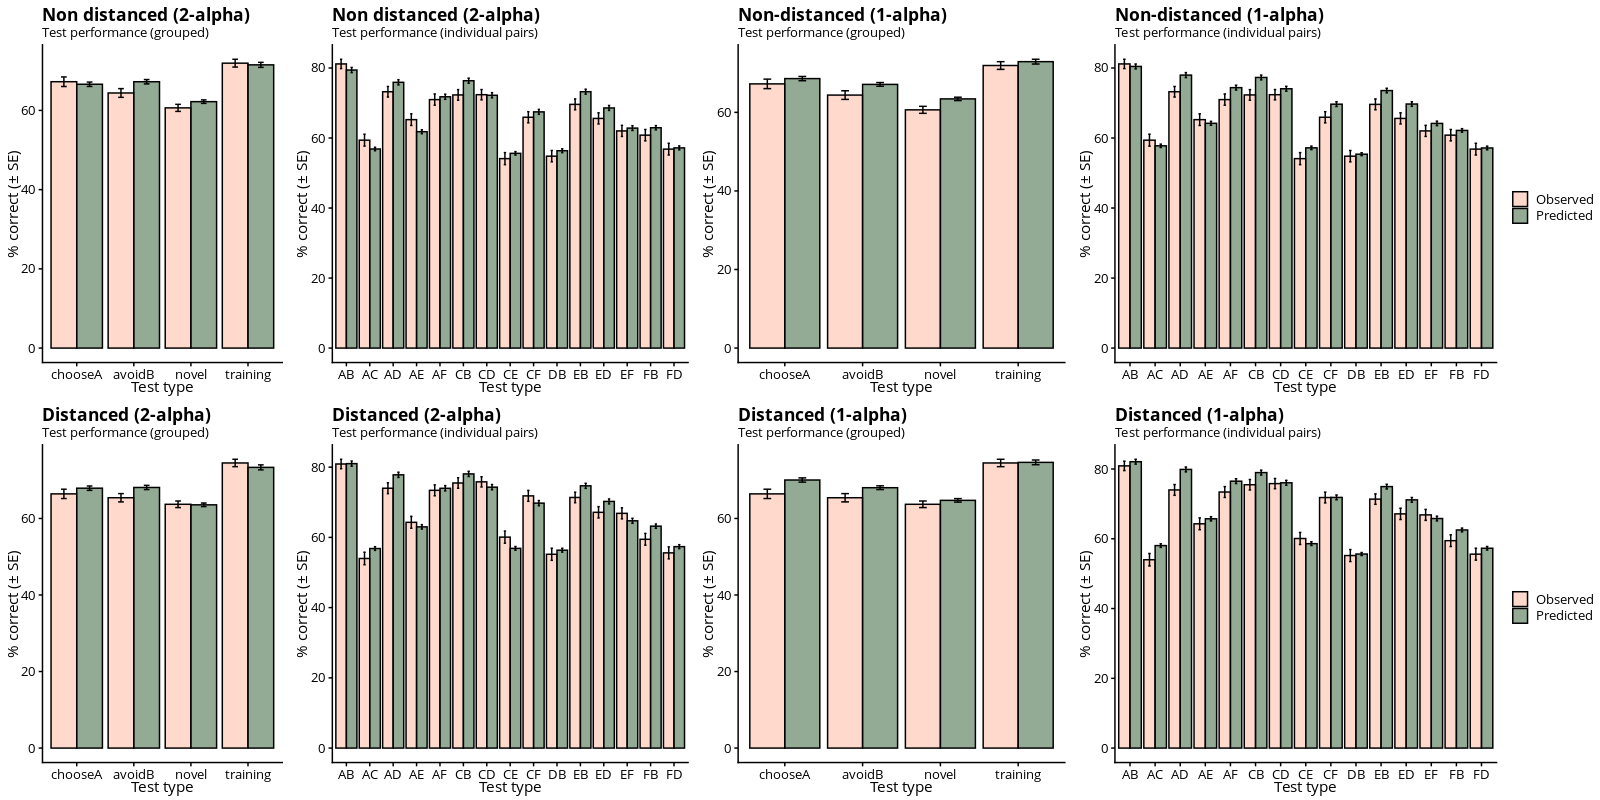

In [52]:
%%R -w 16 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list_test$nd_2a,
    pred_plt_list_test$nd_1a,
    pred_plt_list_test$dis_2a,
    pred_plt_list_test$dis_1a,
    nrow = 2,
    ncol = 2,
    rel_widths = c(1,1.3)
)

In [53]:
%%R
saveRDS(pred_plt_list_test, "outputs/cmdstan/plots/test_posterior_predictions.RDS")

# clear all objects except raw data
rm(list = setdiff(ls(), "all_res_split"))

### Parameter recovery

Finally, we repeat the parameter recovery for the test data.

In [54]:
%%R
dir.create(file.path("outputs/cmdstan/2a_test/model_fits/simulated_data"))
dir.create(file.path("outputs/cmdstan/1a_test/model_fits/simulated_data"))

test_sim_2a <- pstpipeline::simulate_QL(
    sample_size = 500, 
    test = TRUE,
    alpha_pos_dens = c(shape = 2, scale = 0.1),
    alpha_neg_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
test_sim_1a <- pstpipeline::simulate_QL(
    sample_size = 500,
    test = TRUE,
    gain_loss = FALSE,
    alpha_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
saveRDS(test_sim_2a, "outputs/cmdstan/2a_test/model_fits/simulated_data/test_2a_sim.RDS")
saveRDS(test_sim_1a, "outputs/cmdstan/1a_test/model_fits/simulated_data/test_1a_sim.RDS")

  |==============================================================================================================| 100%

In [55]:
%%R
mcmc_2a_test_sim <- pstpipeline::fit_learning_model(
    test_sim_2a$sim, model = "2a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, par_recovery = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a_test/model_fits/simulated_data", 
    refresh = 0, iter_warmup = 4000, iter_sampling = 20000, 
    adapt_delta = 0.9, step_size = 1, max_treedepth = 10
)
rm(mcmc_2a_test_sim)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  96.1 seconds.
Running MCMC with 4 parallel chains...

Chain 3 finished in 75682.5 seconds.
Chain 2 finished in 75796.3 seconds.
Chain 4 finished in 76059.1 seconds.
Chain 1 finished in 76255.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 75948.3 seconds.
Total execution time: 76256.5 seconds.


In [56]:
%%R
mcmc_1a_test_sim <- pstpipeline::fit_learning_model(
    test_sim_1a$sim, model = "1a", exp_part = "test", 
    vb = FALSE, ppc = FALSE, model_checks = FALSE, par_recovery = TRUE,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a_test/model_fits/simulated_data", 
    refresh = 0, iter_warmup = 4000, iter_sampling = 20000, 
    adapt_delta = 0.9, step_size = 1, max_treedepth = 10
)
rm(mcmc_1a_test_sim)

R[write to console]: Model executable is up to date!

R[write to console]: Getting initial values from variational inference...



Finished in  90.4 seconds.
Running MCMC with 4 parallel chains...

Chain 2 finished in 36793.8 seconds.
Chain 1 finished in 36830.1 seconds.
Chain 4 finished in 36939.6 seconds.
Chain 3 finished in 37160.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 36931.0 seconds.
Total execution time: 37162.9 seconds.


#### 2-alpha test data model

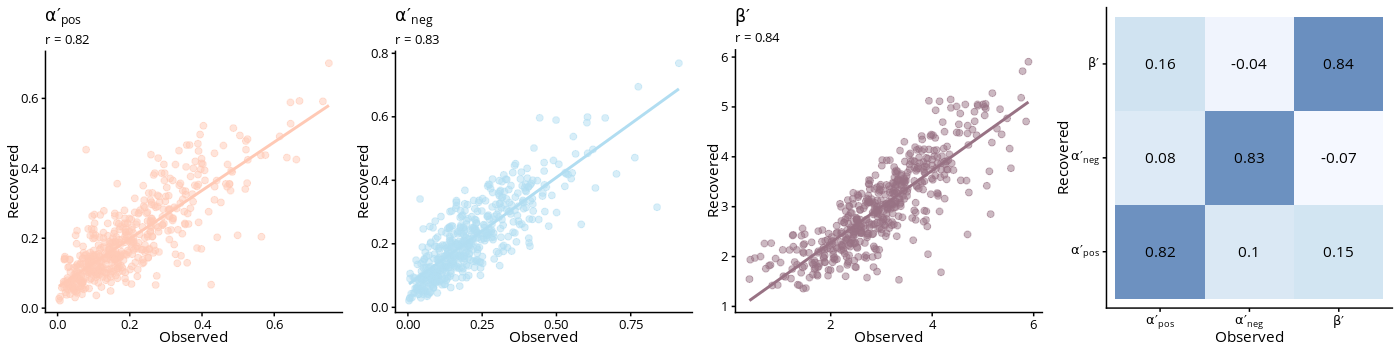

In [57]:
%%R -i light_pal -w 14 -h 3.5 --units in -r 100
sim_pst_test_2a <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/simulated_data/test_2a_sim.RDS"
)
sim_test_2a_fitted <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/simulated_data/fit_pst_test_2a_mcmc_80000_summary.RDS"
)

recovery_plots_test <- list()
recovery_plots_test$gain_loss <- pstpipeline::plot_recovery(
    sim_pst_test_2a$pars, sim_test_2a_fitted, test = TRUE, 
    pal = light_pal, font = "Open Sans"
)
recovery_plots_test$gain_loss

#### 1-alpha test data model

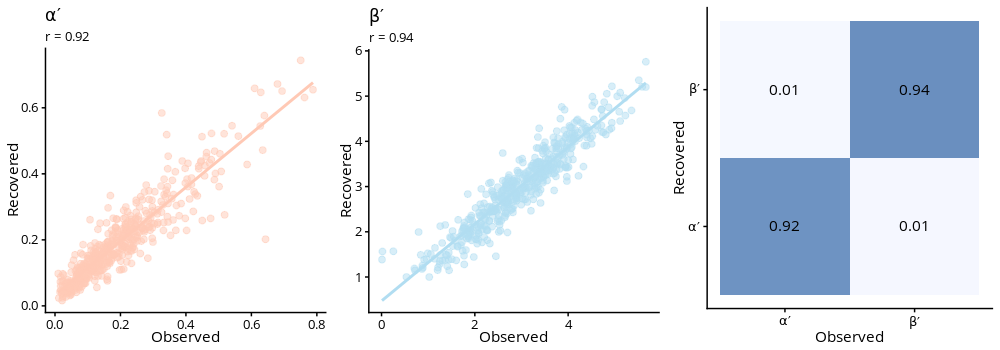

In [58]:
%%R -i light_pal -w 10 -h 3.5 --units in -r 100
sim_pst_test_1a <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/simulated_data/test_1a_sim.RDS"
)
sim_test_1a_fitted <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/simulated_data/fit_pst_test_1a_mcmc_80000_summary.RDS"
)

recovery_plots_test$std_1a <- pstpipeline::plot_recovery(
    sim_pst_test_1a$pars, sim_test_1a_fitted, test = TRUE, 
    pal = light_pal, font = "Open Sans"
)
recovery_plots_test$std_1a

In [59]:
%%R
saveRDS(recovery_plots_test, "outputs/cmdstan/plots/test_parameter_recovery.RDS")
# clear all objects from workspace
rm(list = ls())
invisible(gc())